# Isotonic Regression for Springflow Prediction
##### By Emily Pease, UT Austin
##### 11/18/2019

The Edwards Aquifer Authority (EAA) and all stakeholders need accurate and current springflow data in order to make informed decisions for Comal Springs, especially during drought periods when the endangered species that inhabit the springs are most at risk due to low water levels \cite{lizards}.  However, springflow is difficult to measure directly due to the complexity of numerous seeps and spring orifices and the intermittent presence of rainfall and runoff.  The U.S. Geological Survey (USGS) is the federal agency responsible for correctly measuring the daily spring discharge and the EAA is responsible for regulating discharge through groundwater pumping or withdrawal to ensure the springs are flowing above drought thresholds.  

The current method used by the USGS for measuring springflow at Comal Springs involves separating the springflow component from the streamflow, otherwise referred to as baseflow separation or hydrograph separation \cite{wahl1995determining}.  This method includes some manual estimation of springflow, making this method's results often subjective and time-consuming.  The USGS often needs up to three months to publicly release springflow estimates, though the EAA and other water resource managers need to make daily water use decisions, especially when the aquifer levels are close to drought stage thresholds.  Additionally, these springs are primarily modeled by the EAA using theory-based models to simulate pumping scenarios and drought scenarios.  Here, a springflow prediction model was created using a theory-guided data science approach as a viable option for water resource management. 


### Methods used for feature ranking here include:
1. Summary statistics
2. Visual inspection of scatter matrices and heat maps
3. Correlation coefficients
4. Model-based (LASSO)
5. Domain expertise

### Dataset Description

When performing statistical learning methods on big data, there is often a precompiled dataset containing all parameters for analysis. Here, there was no master dataset of all Edwards Aquifer data and all data used in this study were individually accessed from their respective agencies and  preprocessed prior to model runs.  The individual features selected to be included in the comprehensive Edwards Aquifer dataset are from the EAA, USGS, and National Oceanic and Atmospheric Administration (NOAA).  The time frame for this study is from 1950-01-01 to present using daily data that captures the two major droughts in recent history (1950-1956, 2011-2014). 

Predictor features:
1. J-17: Bexar County index well, located 24 miles from Comal Springs (EAA)
2. J-27: Uvalde County index well, located 106 miles from Comal Springs (EAA)
3. Q$_{riv}$: Comal River discharge ($\frac{ft^3}{s}$) recorded on 15-minute intervals that were then averaged together (USGS)
4. T$_{max}$: maximum recorded daily temperature (NOAA)
5. T$_{min}$: minimum recorded daily temperature (NOAA)
6. $\Delta$ T: daily change in temperature (T$_{max}-$T$_{min}$) (NOAA)
7. P$_{RM}$: trailing rolling mean of preciptiation (t=3 days) (NOAA)

Response feature:
1. Q$_{spg}$: Comal Springs daily mean discharge (USGS)

In [12]:
import os                                                
import numpy as np                                          
import scipy.stats as st                                    
import pandas as pd                                         
import matplotlib.pyplot as plt                             
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import train_test_split        
from sklearn.metrics import explained_variance_score
from sklearn.linear_model import Lasso
import seaborn as sns 
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_white
from statsmodels.stats.diagnostic import het_goldfeldquandt
import pandas as pd
from itertools import repeat
import statsmodels.api as sm
from statsmodels.formula.api import ols
import warnings

warnings.filterwarnings("ignore")
plt.style.use('ggplot')

In [2]:
df = pd.read_csv(os.path.join("..", "data", "ComalPrecipRolling.csv"))
df['datetime'] = pd.to_datetime(df["datetime"])
df = df[df["RvQ"] < 800] # Truncate to remove outliers
# df = df[df["rolling_mean"] > 0.003333] # remove non-impactful precipitation events
df.describe().T

,count,mean,std,min,25%,50%,75%,max
J17Level,23806.0,663.106758,17.412718,612.51,6.509518e+02,664.700000,676.350000,703.3100
J27Level,23806.0,866.982184,16.239798,810.95,8.637000e+02,872.350000,877.427500,889.0500
RvQ,23806.0,281.183928,99.758292,5.50,2.180000e+02,290.000000,347.000000,793.0000
PRCP,23806.0,0.083444,0.275042,0.00,0.000000e+00,0.000000,0.018000,6.5025
TMAX,23806.0,78.113606,14.283710,6.00,6.900000e+01,80.000000,90.000000,109.0000
TMIN,23806.0,53.491305,15.224070,-1.00,4.100000e+01,56.000000,67.000000,84.0000
DeltaT,23806.0,24.622301,8.866411,-40.00,1.900000e+01,24.000000,31.000000,69.0000
SpgQ,23806.0,276.229584,94.605440,0.00,2.150000e+02,290.000000,345.000000,513.0000
rolling_mean,23806.0,0.086904,0.200649,0.00,2.826443e-15,0.003333,0.075556,4.1800
RvSpgDiff,23806.0,0.062501,0.769731,0.00,0.000000e+00,0.000000,0.000000,16.0000


In [3]:
X = df.iloc[:, 1]
y = df.iloc[:, -3]

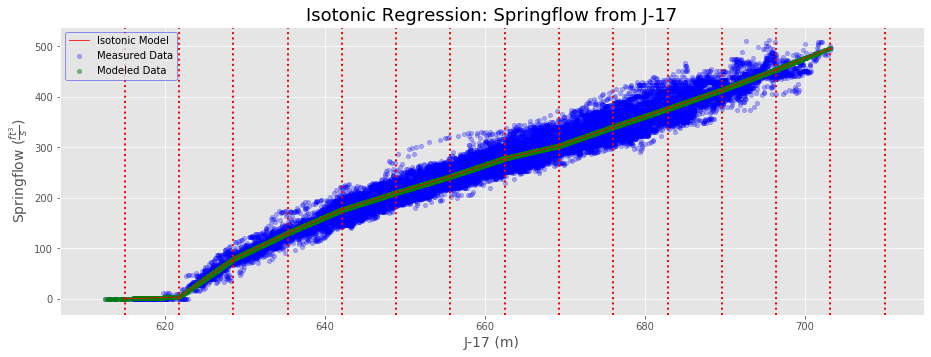

In [4]:
iso_reg = IsotonicRegression().fit(X, y)
X_predict = np.linspace(615,710,15)
y_predict = iso_reg.predict(X_predict)
y_predict_test = np.interp(X, X_predict, y_predict, left=None, right=None, period=None)

# Plot test predictions
plt.subplot(111)
plt.scatter(X, y,  color='blue', s = 20, alpha = 0.3, label='Measured Data')
plt.scatter(X, y_predict_test,  color='green', s = 20, alpha = 0.5, label='Modeled Data')
plt.plot(X_predict, y_predict, color='red', linewidth=.8, label='Isotonic Model')
for threshold in X_predict:
    plt.axvline(threshold, color='red', linewidth=2, linestyle=':', alpha = 1)
plt.title('Isotonic Regression: Springflow from J-17', size=18); 
plt.xlabel('J-17 (m)', size=14); plt.ylabel(r'Springflow ($\frac{ft^3}{s}$)', size=14)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)
leg = plt.legend()
leg.get_frame().set_edgecolor('b')

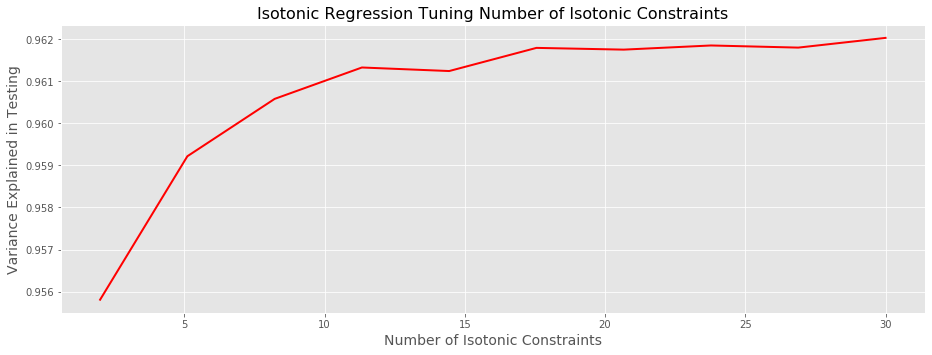

In [5]:
isotonic_constraint_list = np.linspace(2,30,10)
r2 = []

for k in isotonic_constraint_list:
    X_predict = np.linspace(615, 700, k)
    iso_reg = IsotonicRegression().fit(X, y)
    y_predict = iso_reg.predict(X_predict)
    y_predict_test = np.interp(X, X_predict, y_predict, left=None, right=None, period=None)
    r2.append(explained_variance_score(y, y_predict_test))

plt.subplot(111)
plt.plot(isotonic_constraint_list, r2, color='red', linewidth=2, label='model')
plt.title('Isotonic Regression Tuning Number of Isotonic Constraints', size=16);
plt.xlabel('Number of Isotonic Constraints', size=14); plt.ylabel('Variance Explained in Testing', size=14)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)

(-10, 515)

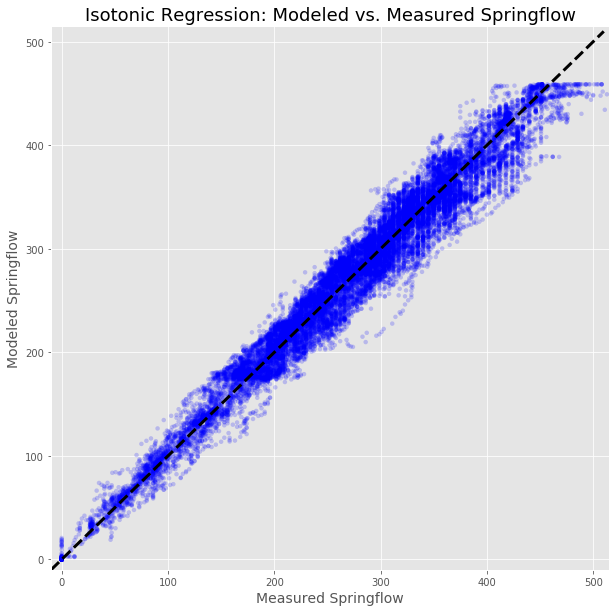

In [6]:
y_predict_test = np.interp(X, X_predict, y_predict, left=None, right=None, period=None)

fig, ax = plt.subplots(figsize=(10,10))
plt.scatter(y, y_predict_test, alpha=0.2, edgecolor='', color='blue', s=20)
plt.plot(np.linspace(-10,510,10), np.linspace(-10,510,10), '--k', linewidth=3)
plt.title('Isotonic Regression: Modeled vs. Measured Springflow', size=18); 
plt.xlabel('Measured Springflow', size=14); plt.ylabel(r'Modeled Springflow', size=14)
plt.xlim(-10, 515); plt.ylim(-10,515)

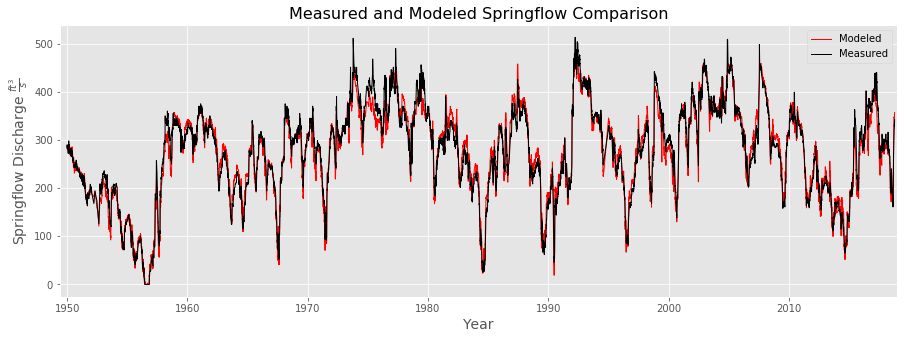

In [7]:
fig, ax = plt.subplots(figsize=(15,5))

ax.plot(df['datetime'], y_predict_test, color='red',   linestyle='-', linewidth=1, alpha=1, label='Modeled')
ax.plot(df['datetime'],   df["SpgQ"],   color='black', linestyle='-', linewidth=1, alpha=1, label='Measured')

plt.title("Measured and Modeled Springflow Comparison", size=16)
plt.xlabel("Year", size=14); plt.ylabel(r"Springflow Discharge $\frac{ft^3}{s}$", size=14)
plt.xlim("1949-06-01", "2019-01-01")
plt.legend()

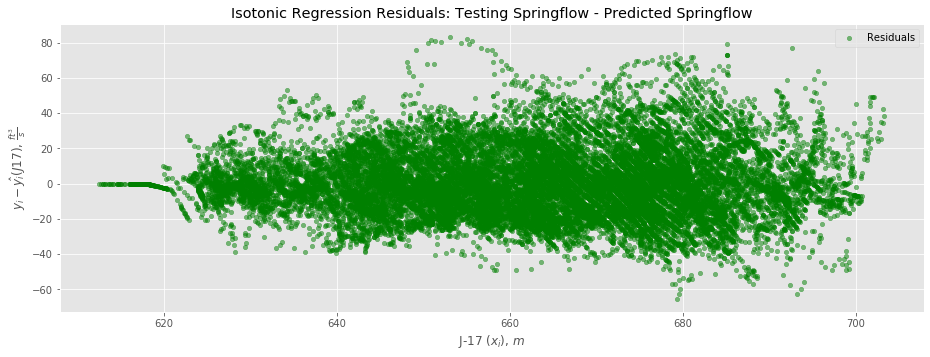

In [8]:
residuals = y-y_predict_test
df["Residual"] = residuals
df["Spg_IsoPred"] = y_predict_test

plt.subplot(111)
plt.scatter(X, residuals,  color='green', s = 20, alpha = 0.5, label='Residuals')
plt.title('Isotonic Regression Residuals: Testing Springflow - Predicted Springflow'); 
plt.xlabel(r'J-17 ($x_i$), $m$'); plt.ylabel(r'$y_i-\hat{y_i}(J17)$, $\frac{ft^3}{s}$')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)
plt.legend()

(711644.0, 737060.0)

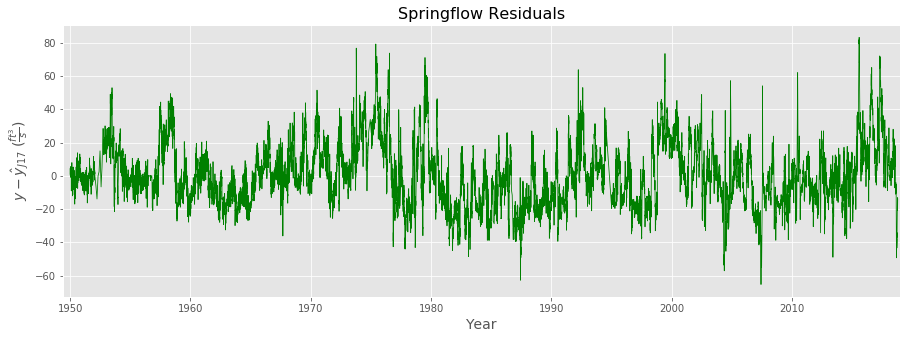

In [9]:
fig, ax = plt.subplots(figsize=(15,5))
plt.plot(df['datetime'], df["Residual"], color='g', linewidth=0.8)
plt.xlabel("Year", size=14); plt.ylabel(r'$y-\hat{y}_{J17}$ ($\frac{ft^3}{s}$)', size=14)
plt.title("Springflow Residuals", size=16)
plt.xlim("1949-06-01", "2019-01-01")

In [10]:
X_predict0 = X_predict.tolist()
X_predict0 = [0]+X_predict0
X_predict = list(X_predict)

In [13]:
mins = [];maxs = [];P1s  = [];P5s  = [];P10s = [];P25s = [];P35s = [];P50s = [];P65s = [];P75s = [];
P90s = [];P95s = []; P99s = [];preds_in_df = []

mins_ = []
maxs_ = []

temp_df = df[df["J17Level"] <= X_predict0[1]]
temp_df['diff'] = temp_df["SpgQ"] - temp_df["Spg_IsoPred"]
preds_in_df.extend(repeat(X_predict0[0], len(temp_df)))
P25 = np.percentile(temp_df["diff"], 25)
P75 = np.percentile(temp_df["diff"], 75)
mins_.extend(repeat(P25, len(temp_df)))
maxs_.extend(repeat(P75, len(temp_df)))

for i in range(1, len(X_predict0)-1):
    temp_df = df[(df["J17Level"] > X_predict0[i]) & (df["J17Level"] <= X_predict0[i+1])]
    temp_df['diff'] = temp_df["SpgQ"] - temp_df["Spg_IsoPred"]
    preds_in_df.extend(repeat(X_predict0[i+1], len(temp_df)))
    P1  = np.percentile(temp_df["diff"], 1);  P1s.append(P1)
    P5  = np.percentile(temp_df["diff"], 5);  P5s.append(P5)
    P10 = np.percentile(temp_df["diff"], 10); P10s.append(P10)
    P25 = np.percentile(temp_df["diff"], 25); P25s.append(P25)
    P50 = np.percentile(temp_df["diff"], 50); P50s.append(P50)
    P75 = np.percentile(temp_df["diff"], 75); P75s.append(P75)
    P90 = np.percentile(temp_df["diff"], 90); P90s.append(P90)
    P95 = np.percentile(temp_df["diff"], 95); P95s.append(P95)
    P99 = np.percentile(temp_df["diff"], 99); P99s.append(P99)
    P35 = np.percentile(temp_df["diff"], 35); P35s.append(P35)
    P65 = np.percentile(temp_df["diff"], 65); P65s.append(P65)
    mins.append(temp_df["diff"].min())
    maxs.append(temp_df["diff"].max())
    mins_.extend(repeat(P25, len(temp_df)))
    maxs_.extend(repeat(P75, len(temp_df)))

temp_df = df[df["J17Level"] > X_predict0[-1]]
temp_df['diff'] = temp_df["SpgQ"] - temp_df["Spg_IsoPred"]
preds_in_df.extend(repeat(X_predict0[-1], len(temp_df)))

P25 = np.percentile(temp_df["diff"], 25)
P75 = np.percentile(temp_df["diff"], 75)
mins_.extend(repeat(P25, len(temp_df)))
maxs_.extend(repeat(P75, len(temp_df)))

In [14]:
df.sort_values(by='J17Level', inplace=True)
df["Xpred"] = preds_in_df
df["Xpred"] = df["Xpred"].astype(int)

new_ls = np.zeros(len(preds_in_df))
new_ls = np.digitize(x=df['J17Level'], bins=X_predict0, right=False)
df["XpredBin"] = new_ls
df['Xpred'] = df.apply(lambda i: X_predict0[i['XpredBin']-1],axis=1)
df["Xpred"] = df["Xpred"].astype(int)

df["Mins"] = mins_
df["Maxs"] = maxs_

,datetime,J17Level,J27Level,RvQ,PRCP,TMAX,TMIN,DeltaT,SpgQ,rolling_mean,RvSpgDiff,Residual,Spg_IsoPred,Xpred,XpredBin,Mins,Maxs
2063,1956-08-17,612.51,816.65,11.0,0.00,96.0,63.0,33.0,0.0,0.000000e+00,11.0,0.000,0.000,0,1,0.000,0.000
2062,1956-08-16,612.74,816.75,10.0,0.00,99.0,67.0,32.0,0.0,0.000000e+00,10.0,0.000,0.000,0,1,0.000,0.000
2061,1956-08-15,613.00,816.75,11.0,0.00,99.0,70.0,29.0,0.0,6.000000e-02,0.0,0.000,0.000,0,1,0.000,0.000
2065,1956-08-19,613.02,816.65,11.0,0.00,97.0,71.0,26.0,0.0,0.000000e+00,11.0,0.000,0.000,0,1,0.000,0.000
2060,1956-08-14,613.20,816.95,11.0,0.00,98.0,67.0,31.0,0.0,6.000000e-02,0.0,0.000,0.000,0,1,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14554,1992-06-16,702.91,884.65,484.0,0.00,90.0,73.0,17.0,484.0,3.441691e-15,0.0,25.125,458.875,700,31,-6.875,30.125
14550,1992-06-12,702.95,884.25,503.0,0.35,90.0,65.0,25.0,494.0,6.041667e-01,0.0,35.125,458.875,700,31,-6.875,30.125
14551,1992-06-13,703.18,884.45,501.0,0.00,90.0,65.0,25.0,501.0,3.216667e-01,0.0,42.125,458.875,700,31,-6.875,30.125
14553,1992-06-15,703.19,884.65,493.0,0.00,88.0,73.0,15.0,493.0,3.441691e-15,0.0,34.125,458.875,700,31,-6.875,30.125


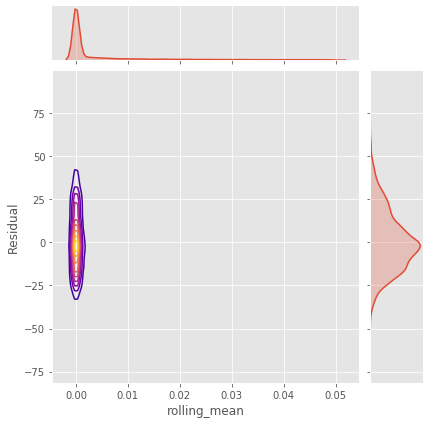

In [37]:
df2 = df[df["rolling_mean"] <0.05] # truncate to better visualize
sns.jointplot(df2['rolling_mean'], df2['Residual'], df2, kind='kde', shade=False, n_levels=10, cmap=cmap)


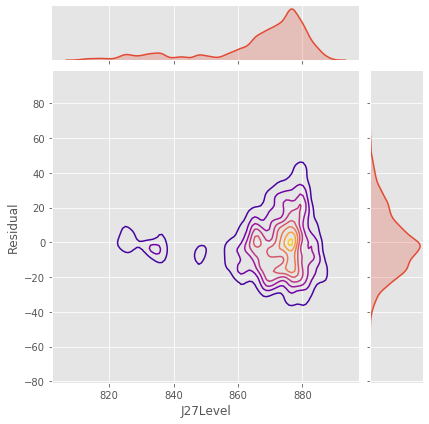

In [38]:
ax = sns.jointplot(df['J27Level'], df['Residual'], df, kind='kde',shade = False, 
                   n_levels = 10,cmap=plt.cm.plasma, shade_lowest = True);

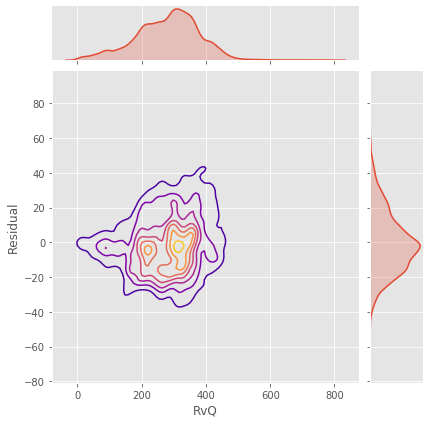

In [39]:
ax = sns.jointplot(df['RvQ'], df['Residual'], df, kind='kde',shade = False, 
                   n_levels = 10,cmap=plt.cm.plasma, shade_lowest = True);

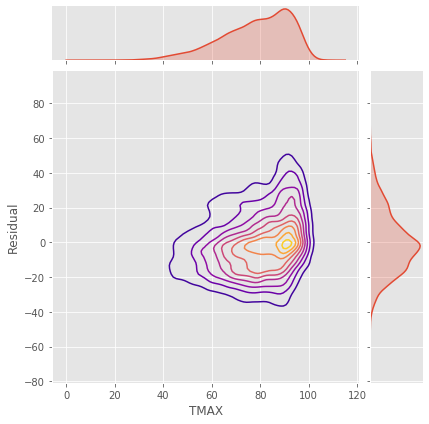

In [41]:
ax = sns.jointplot(df['TMAX'], df['Residual'], df, kind='kde',shade = False, 
                   n_levels = 10,cmap=plt.cm.plasma, shade_lowest = True);

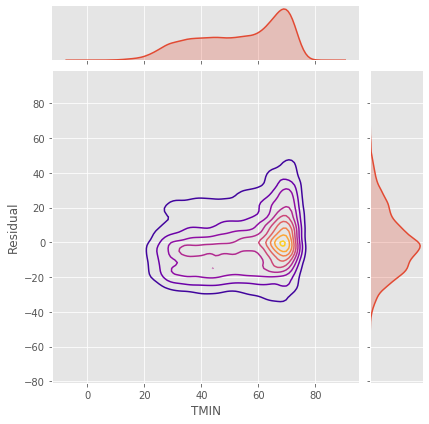

In [42]:
ax = sns.jointplot(df['TMIN'], df['Residual'], df, kind='kde',shade = False, 
                   n_levels=10, cmap=plt.cm.plasma, shade_lowest = True);

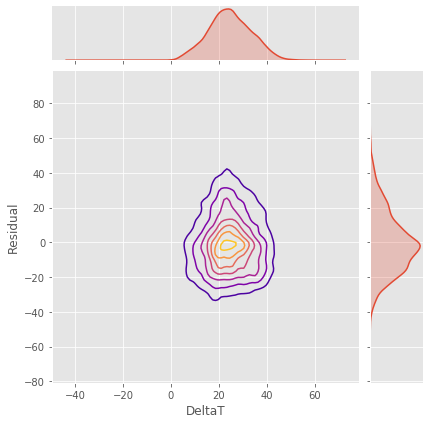

In [43]:
ax = sns.jointplot(df['DeltaT'], df['Residual'], df, kind='kde',shade = False, 
                   n_levels = 10,cmap=plt.cm.plasma, shade_lowest = True);

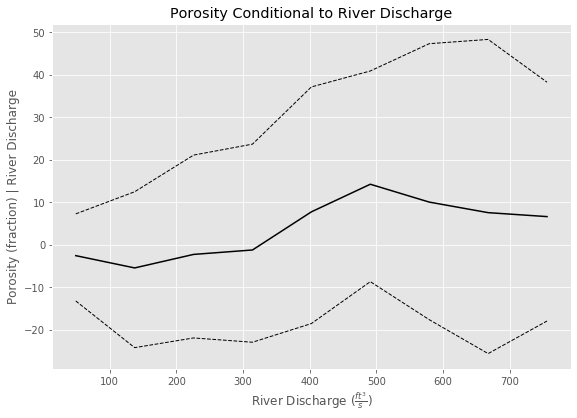

In [58]:
RvQ_bins = np.linspace(5, 800, 10)          # set the bin boundaries and then the centroids for plotting
RvQ_centroids = np.linspace((RvQ_bins[0]+RvQ_bins[1])*0.5,(RvQ_bins[8]+RvQ_bins[9])*0.5,9)
df['RvQ_bins'] = pd.cut(df['RvQ'], RvQ_bins, labels = RvQ_centroids) # cut on bondaries and lable with centroids 
df.head()   

cond_exp = df.groupby('RvQ_bins')['Residual'].mean()
cond_P90 = df.groupby('RvQ_bins')['Residual'].quantile(.9)
cond_P10 = df.groupby('RvQ_bins')['Residual'].quantile(.1)

plt.subplot(111)
plt.plot(RvQ_centroids,cond_exp,color='black')
plt.plot(RvQ_centroids,cond_P90,'r--',color='black',linewidth = 1.0)
plt.plot(RvQ_centroids,cond_P10,'r--',color='black',linewidth = 1.0)

plt.xlabel(r'River Discharge $(\frac{ft^3}{s})$')
plt.ylabel('Porosity (fraction) | River Discharge')
t = plt.title('Porosity Conditional to River Discharge')

plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

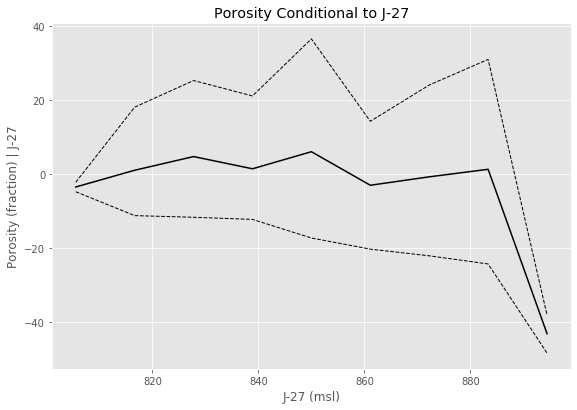

In [60]:
J27_bins = np.linspace(800, 900, 10)          # set the bin boundaries and then the centroids for plotting
J27_centroids = np.linspace((J27_bins[0]+J27_bins[1])*0.5,(J27_bins[8]+J27_bins[9])*0.5,9)

df['J27_bins'] = pd.cut(df['J27Level'], J27_bins, labels = J27_centroids) # cut on bondaries and lable with centroids 

cond_exp = df.groupby('J27_bins')['Residual'].mean()
cond_P90 = df.groupby('J27_bins')['Residual'].quantile(.9)
cond_P10 = df.groupby('J27_bins')['Residual'].quantile(.1)

plt.subplot(111)
# f = plt.figure(figsize=(40,20))
plt.plot(J27_centroids,cond_exp,color='black')
plt.plot(J27_centroids,cond_P90,'r--',color='black',linewidth = 1.0)
plt.plot(J27_centroids,cond_P10,'r--',color='black',linewidth = 1.0)

plt.xlabel('J-27 (msl)')
plt.ylabel('Porosity (fraction) | J-27')
t = plt.title('Porosity Conditional to J-27')

plt.grid(True)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

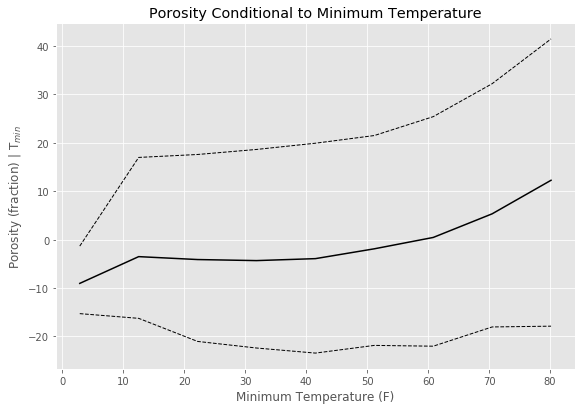

In [53]:
TMIN_bins = np.linspace(-2, 85, 10)          # set the bin boundaries and then the centroids for plotting
TMIN_centroids = np.linspace((TMIN_bins[0]+TMIN_bins[1])*0.5,(TMIN_bins[8]+TMIN_bins[9])*0.5,9)

df['TMIN_bins'] = pd.cut(df['TMIN'], TMIN_bins, labels = TMIN_centroids) # cut on bondaries and lable with centroids 
cond_exp = df.groupby('TMIN_bins')['Residual'].mean()
cond_P90 = df.groupby('TMIN_bins')['Residual'].quantile(.9)
cond_P10 = df.groupby('TMIN_bins')['Residual'].quantile(.1)

plt.subplot(111)
plt.plot(TMIN_centroids,cond_exp,color='black')
plt.plot(TMIN_centroids,cond_P90,'r--',color='black',linewidth = 1.0)
plt.plot(TMIN_centroids,cond_P10,'r--',color='black',linewidth = 1.0)

plt.xlabel('Minimum Temperature (F)')
plt.ylabel(r'Porosity (fraction) | T$_{min}$')
t = plt.title('Porosity Conditional to Minimum Temperature')
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=1.2, wspace=0.2, hspace=0.2)

plt.grid(True)
plt.show()

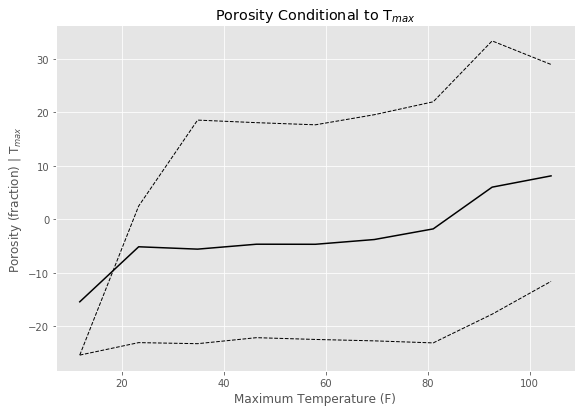

In [67]:
TMAX_bins = np.linspace(6, 110, 10)          # set the bin boundaries and then the centroids for plotting
TMAX_centroids = np.linspace((TMAX_bins[0]+TMAX_bins[1])*0.5,(TMAX_bins[8]+TMAX_bins[9])*0.5,9)

df['TMAX_bins'] = pd.cut(df['TMAX'], TMAX_bins, labels = TMAX_centroids) 
df.head()   

cond_exp = df.groupby('TMAX_bins')['Residual'].mean()
cond_P90 = df.groupby('TMAX_bins')['Residual'].quantile(.9)
cond_P10 = df.groupby('TMAX_bins')['Residual'].quantile(.1)

plt.subplot(111)
plt.plot(TMAX_centroids,cond_exp,color='black')
plt.plot(TMAX_centroids,cond_P90,'r--',color='black',linewidth = 1.0)
plt.plot(TMAX_centroids,cond_P10,'r--',color='black',linewidth = 1.0)

plt.xlabel('Maximum Temperature (F)')
plt.ylabel(r'Porosity (fraction) | T$_{max}$')
t = plt.title('Porosity Conditional to T$_{max}$')

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=1.2, wspace=0.2, hspace=0.2)

plt.grid(True)
plt.show()

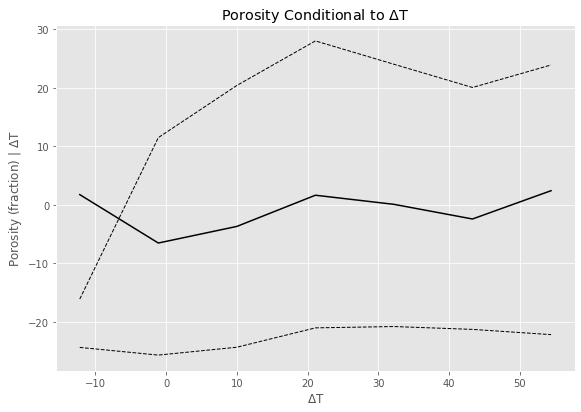

In [61]:
DeltaT_bins = np.linspace(-40, 60, 10)          # set the bin boundaries and then the centroids for plotting
DeltaT_centroids = np.linspace((DeltaT_bins[0]+DeltaT_bins[1])*0.5,(DeltaT_bins[8]+DeltaT_bins[9])*0.5,9)

df['DeltaT_bins'] = pd.cut(df['DeltaT'], DeltaT_bins, labels = DeltaT_centroids) 
df.head()   

cond_exp = df.groupby('DeltaT_bins')['Residual'].mean()
cond_P90 = df.groupby('DeltaT_bins')['Residual'].quantile(.9)
cond_P10 = df.groupby('DeltaT_bins')['Residual'].quantile(.1)

plt.subplot(111)
plt.plot(DeltaT_centroids,cond_exp,color='black')
plt.plot(DeltaT_centroids,cond_P90,'r--',color='black',linewidth = 1.0)
plt.plot(DeltaT_centroids,cond_P10,'r--',color='black',linewidth = 1.0)

plt.xlabel(r'$\Delta$T')
plt.ylabel(r'Porosity (fraction) | $\Delta$T')
t = plt.title('Porosity Conditional to $\Delta$T')

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=1.2, wspace=0.2, hspace=0.2)

plt.grid(True)
plt.show()

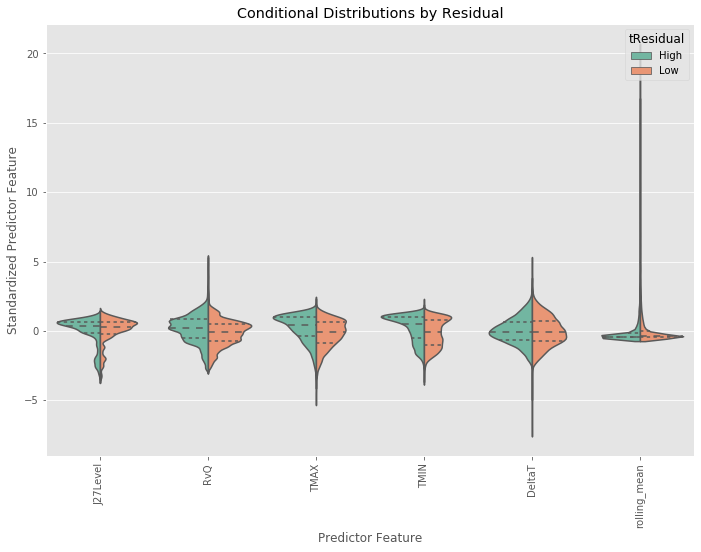

In [68]:
df['tResidual'] = np.where(df['Residual']>= -1, 'High', 'Low') # make a high and low production categorical feature

x = df[['J27Level', "RvQ", "TMAX", "TMIN", "DeltaT", "rolling_mean"]]
x_stand = (x - x.mean()) / (x.std())      # standardization by feature
x = pd.concat([df['tResidual'],x_stand.iloc[:,0:6]],axis=1) # add the production categorical feature to the DataFrame
x = pd.melt(x,id_vars="tResidual",var_name="Predictor Feature",value_name='Standardized Predictor Feature') 

plt.subplot(111)
sns.violinplot(x="Predictor Feature", y="Standardized Predictor Feature", hue="tResidual", data=x,split=True, 
               inner="quart", palette="Set2")
plt.xticks(rotation=90); plt.title('Conditional Distributions by Residual')
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1.5, wspace=0.2, hspace=0.2)
plt.show()

       J27Level    RvQ  TMAX  TMIN  DeltaT  rolling_mean
2063     816.65   11.0  96.0  63.0    33.0  0.000000e+00
2062     816.75   10.0  99.0  67.0    32.0  0.000000e+00
2061     816.75   11.0  99.0  70.0    29.0  6.000000e-02
2065     816.65   11.0  97.0  71.0    26.0  0.000000e+00
2060     816.95   11.0  98.0  67.0    31.0  6.000000e-02
...         ...    ...   ...   ...     ...           ...
14554    884.65  484.0  90.0  73.0    17.0  3.441691e-15
14550    884.25  503.0  90.0  65.0    25.0  6.041667e-01
14551    884.45  501.0  90.0  65.0    25.0  3.216667e-01
14553    884.65  493.0  88.0  73.0    15.0  3.441691e-15
14552    884.55  497.0  89.0  71.0    18.0  1.166667e-01

[23806 rows x 6 columns]
Feature ranking:
1. feature 0 (0.376913)
2. feature 1 (0.305568)
3. feature 2 (0.140471)
4. feature 5 (0.068459)
5. feature 3 (0.064366)
6. feature 4 (0.044222)


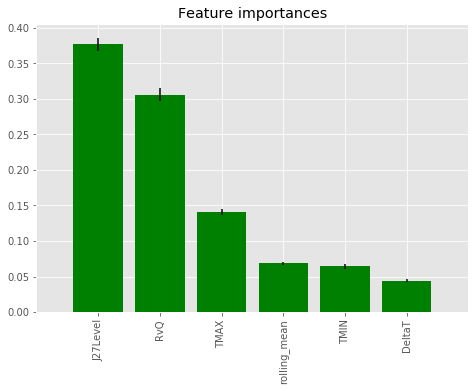

In [69]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
import warnings                           # silence warnings that commonly occur with random forest
warnings.filterwarnings('ignore')     

x = df.iloc[:,[2,3,5,6,7, 9]]              # separate DataFrames for predictor and response features
print(x)
y = df["Residual"]

lab_enc = preprocessing.LabelEncoder(); y_encoded = lab_enc.fit_transform(y) # this removes an encoding error 

random_forest = RandomForestRegressor()   # instantiate the random forest  
random_forest = random_forest.fit(x,np.ravel(y_encoded)) # fit the random forest
importances = random_forest.feature_importances_ # extract the expected feature importances
std = np.std([tree.feature_importances_ for tree in random_forest.estimators_],axis=0) # calculate stdev over trees
indices = np.argsort(importances)[::-1]   # find indicies for descending order

print("Feature ranking:")                 # write out the feature importances
for f in range(x.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

plt.subplot(111)                          # plot the feature importance 
plt.title("Feature importances")
plt.bar(range(x.shape[1]), importances[indices],
       color="g", yerr=std[indices], align="center")
plt.xticks(range(x.shape[1]), x.columns[indices],rotation=90)
plt.xlim([-1, x.shape[1]])
plt.savefig("FeatureImportances.png")

plt.subplots_adjust(left=0.0, bottom=0.0, right=1., top=1., wspace=0.2, hspace=0.2)
plt.show()

       J27Level    RvQ  TMAX  TMIN  DeltaT  rolling_mean
2063     816.65   11.0  96.0  63.0    33.0  0.000000e+00
2062     816.75   10.0  99.0  67.0    32.0  0.000000e+00
2061     816.75   11.0  99.0  70.0    29.0  6.000000e-02
2065     816.65   11.0  97.0  71.0    26.0  0.000000e+00
2060     816.95   11.0  98.0  67.0    31.0  6.000000e-02
...         ...    ...   ...   ...     ...           ...
14554    884.65  484.0  90.0  73.0    17.0  3.441691e-15
14550    884.25  503.0  90.0  65.0    25.0  6.041667e-01
14551    884.45  501.0  90.0  65.0    25.0  3.216667e-01
14553    884.65  493.0  88.0  73.0    15.0  3.441691e-15
14552    884.55  497.0  89.0  71.0    18.0  1.166667e-01

[23806 rows x 6 columns]
Feature ranking:
1. feature 0 (0.376913)
2. feature 1 (0.305568)
3. feature 2 (0.140471)
4. feature 3 (0.064366)
5. feature 5 (0.068459)
6. feature 4 (0.044222)


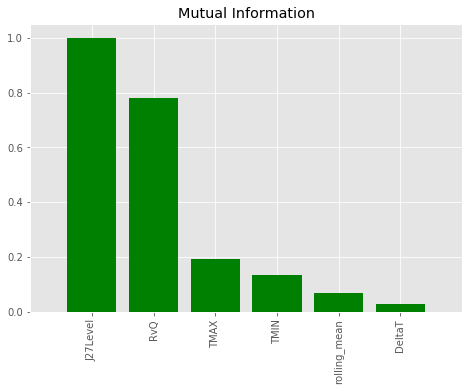

In [70]:
from sklearn.feature_selection import mutual_info_regression

x = df.iloc[:,[2,3,5,6,7, 9]]              # separate DataFrames for predictor and response features
print(x)
y = df["Residual"]

mi = mutual_info_regression(x,np.ravel(y_encoded)) # calculate mutual information
mi /= np.max(mi)                          # calculate relative mutual information

indices = np.argsort(mi)[::-1]            # find indicies for descending order

print("Feature ranking:")                 # write out the feature importances
for f in range(x.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

plt.subplot(111)                          # plot the relative mutual information 
plt.title("Mutual Information")
plt.bar(range(x.shape[1]), mi[indices],
       color="g", align="center")
plt.xticks(range(x.shape[1]), x.columns[indices],rotation=90)
plt.xlim([-1, x.shape[1]])
plt.subplots_adjust(left=0.0, bottom=0.0, right=1., top=1., wspace=0.2, hspace=0.2)
plt.show()

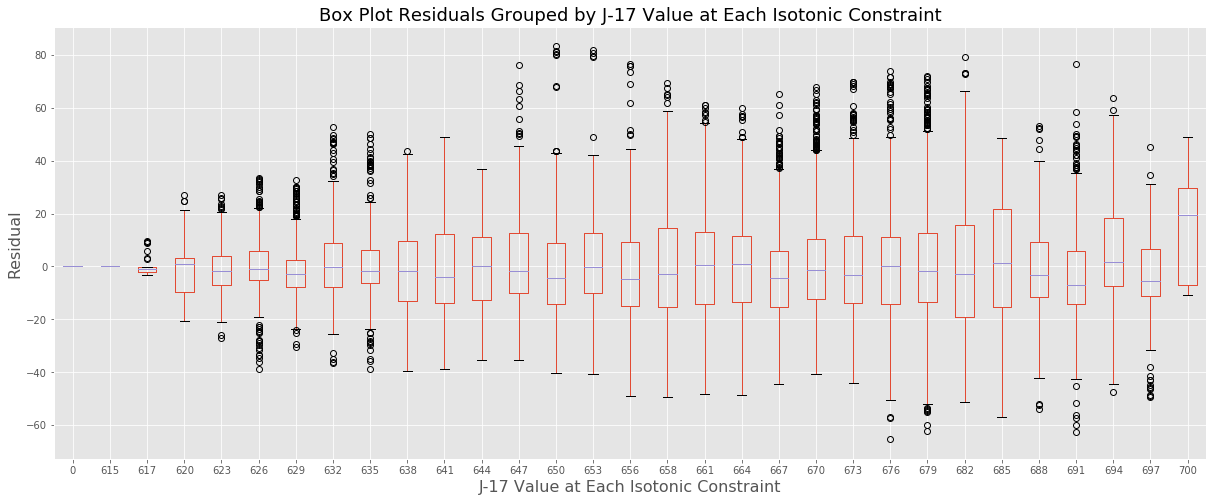

In [72]:
j = df.boxplot(column='Residual', by='Xpred', figsize=(20,8));

plt.suptitle("")
plt.title("Box Plot Residuals Grouped by J-17 Value at Each Isotonic Constraint", size=18)
plt.xlabel("J-17 Value at Each Isotonic Constraint", size=16)
plt.ylabel("Residual", size=16);

# plot 10 and -10 line

In [74]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle

df = shuffle(df)
X = df["J17Level"]
y = df["SpgQ"]

X = np.array(X)
y = np.array(y)

isotonic_constraint_list = np.linspace(2,30,10)
# X, y

kf = KFold(n_splits=5)
print(kf)
isotonic_constraint_list = np.linspace(2,30,10)
R2_ = np.zeros((5,10)); flag_1=0
MSE_= np.zeros((5,10)); flag_2=0

for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    for k in isotonic_constraint_list:
        X_predict = np.linspace(615, 700, k)
        iso_reg = IsotonicRegression()
        iso_reg.fit(X_train, y_train)
        y_predict = iso_reg.predict(X_predict)
        y_predict_test = np.interp(X_test, X_predict, y_predict, left=None, right=None, period=None)
        r2 = explained_variance_score(y_test, y_predict_test)
        mse = mean_squared_error(y_test, y_predict_test)
        R2_[flag_1, flag_2] = r2
        MSE_[flag_1, flag_2] = mse
        flag_2 = flag_2 +1
    flag_2 = 0
    flag_1 = flag_1 + 1

KFold(n_splits=5, random_state=None, shuffle=False)
TRAIN: [ 4762  4763  4764 ... 23803 23804 23805] TEST: [   0    1    2 ... 4759 4760 4761]
TRAIN: [    0     1     2 ... 23803 23804 23805] TEST: [4762 4763 4764 ... 9520 9521 9522]
TRAIN: [    0     1     2 ... 23803 23804 23805] TEST: [ 9523  9524  9525 ... 14281 14282 14283]
TRAIN: [    0     1     2 ... 23803 23804 23805] TEST: [14284 14285 14286 ... 19042 19043 19044]
TRAIN: [    0     1     2 ... 19042 19043 19044] TEST: [19045 19046 19047 ... 23803 23804 23805]


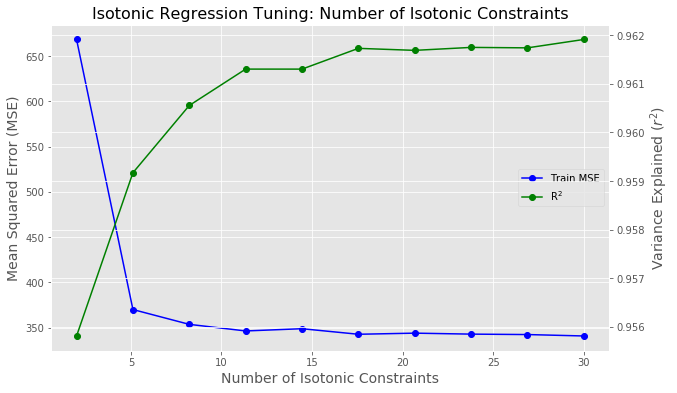

In [76]:
R2_mean = np.mean(R2_,axis=0)
MSE_mean = np.mean(MSE_,axis=0)

fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()
lns1 = ax1.plot(isotonic_constraint_list, MSE_mean, label="Train MSE", color='blue', marker='o')
lns2 = ax2.plot(isotonic_constraint_list, R2_mean , label="R$^2$", color='green', marker='o')

ax1.set_title("Isotonic Regression Tuning: Number of Isotonic Constraints", size=16)
ax1.set_ylabel("Mean Squared Error (MSE)", size=14)
ax2.set_ylabel("Variance Explained ($r^2$)", size=14)
ax1.set_xlabel("Number of Isotonic Constraints", size=14)

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='center right')